In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import arviz as az
import pandas as pd
from datetime import datetime
import json
import argparse

import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal, RandomWalkKernel
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.mcmc.util import TraceEinsumEvaluator
from torch.autograd import grad

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.func import jacrev

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from Initial_model import *
from model import MyModel

dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import dolfin as dl
import ufl

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

import logging
import math
import numpy as np

import matplotlib.pyplot as plt

from train_nn import *
#%matplotlib inline

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)
from pyro.nn import PyroModule, PyroSample

from mpi4py import MPI

In [24]:
def create_initial_gempy_model_3_layer(refinement,filename, save=True):
    """ Create an initial gempy model objet

    Args:
        refinement (int): Refinement of grid
        save (bool, optional): Whether you want to save the image

    """
    geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',  
    extent=[0, 1, -0.1, 0.1, 0, 1], 
    resolution=[100,10,100],             
    refinement=refinement,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
   
    brk1 = 0.3
    brk2 = 0.5
    
    
    gp.add_surface_points(
        geo_model=geo_model_test,
        x=[0.1,0.5, 0.9],
        y=[0.0, 0.0, 0.0],
        z=[brk1, brk1 , brk1],
        elements_names=['surface1','surface1', 'surface1']
    )

    gp.add_orientations(
        geo_model=geo_model_test,
        x=[0.5],
        y=[0.0],
        z=[0.0],
        elements_names=['surface1'],
        pole_vector=[[0, 0, 0.5]]
    )
    geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

    element2 = gp.data.StructuralElement(
        name='surface2',
        color=next(geo_model_test.structural_frame.color_generator),
        surface_points=gp.data.SurfacePointsTable.from_arrays(
            x=np.array([0.1,0.5, 0.9]),
            y=np.array([0.0, 0.0, 0.0]),
            z=np.array([brk2, brk2, brk2]),
            names='surface2'
        ),
        orientations=gp.data.OrientationsTable.initialize_empty()
    )
    
    
    geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)
    
    geo_model_test.structural_frame.structural_groups[0].append_element(element2)
    gp.add_orientations(
        geo_model=geo_model_test,
        x=[0.5],
        y=[0.0],
        z=[1.0],
        elements_names=['surface2'],
        pole_vector=[[0, 0, 0.5]]
    )
    geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1] = \
    geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0]

    gp.compute_model(geo_model_test)
    picture_test = gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    plt.show()
    if save:
        plt.savefig(filename)
    
    return geo_model_test

Process 0 of 1
Directory './Results' already exists.
Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


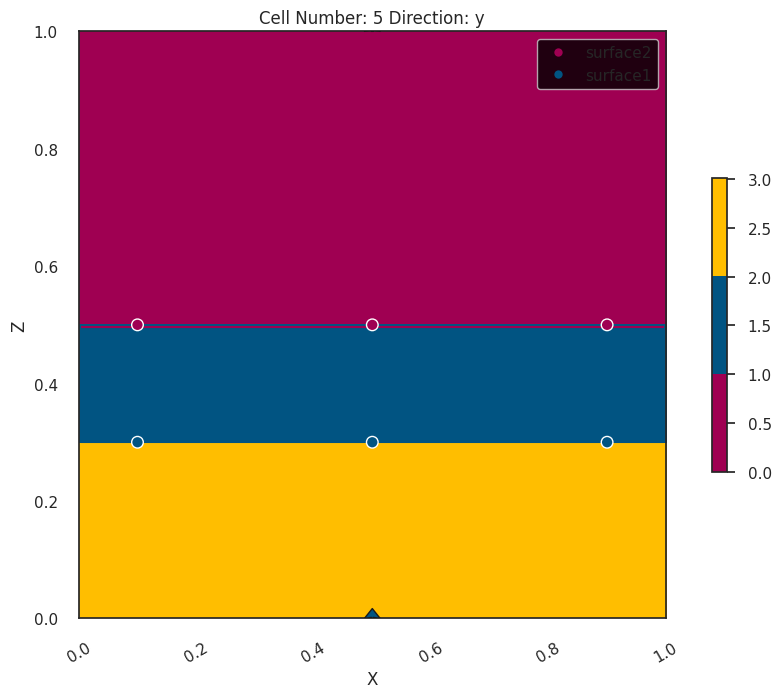

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


<Figure size 1040x715 with 0 Axes>

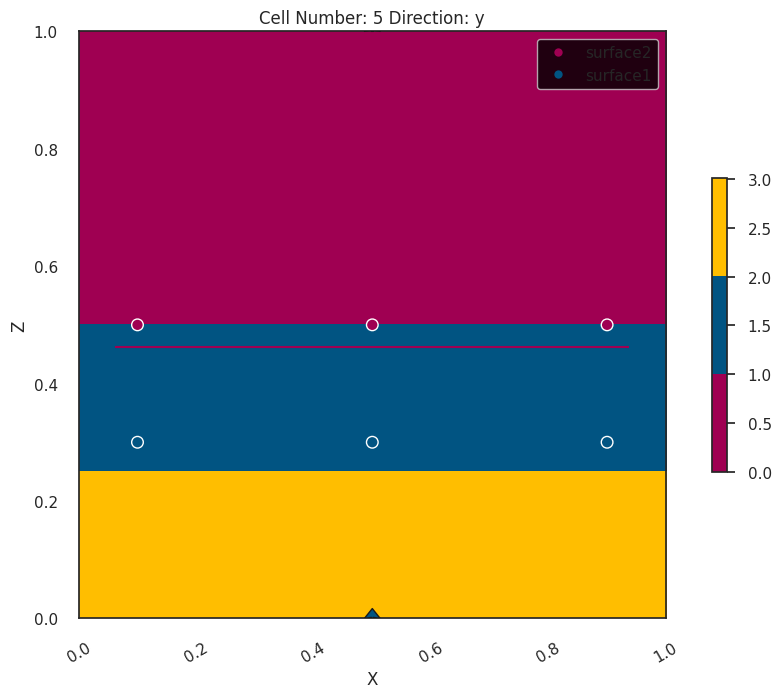

In [25]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
    
comm.Barrier()
print(f"Process {rank} of {size}")


###############################################################################
# Seed the randomness 
###############################################################################
seed = 42           
np.random.seed(seed)
torch.manual_seed(seed)
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Setting the seed for Pyro sampling
pyro.set_rng_seed(42)

###############################################################################
# Create a directory to store plots and results
###############################################################################
directory_path = "./Results"
if not os.path.exists(directory_path):
    # Create the directory if it does not exist
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' was created.")
else:
    print(f"Directory '{directory_path}' already exists.")
    
################################################################################
# Create initial model with higher refinement for better resolution and save it
###############################################################################
'''
    Gempy is a package which is based on universal cokriging approach. It is similar to Gaussian 
    process. Thus, it creates a covariance matrix based on input parameters and find the value of
    scalar field at new location. So value of scalar field at new location is dependent on the input
    parameters directly but not on whole grid. Therefore setting refinement higher is good for plotting 
    whereas as it has no effect on find value at an new location. 
'''
prior_filename=  directory_path + "/prior_model.png" 
geo_model_test = create_initial_gempy_model_3_layer(refinement=7,filename=prior_filename, save=True)
# We can initialize again but with lower refinement because gempy solution are inddependent
geo_model_test = create_initial_gempy_model_3_layer(refinement=3,filename=prior_filename, save=False)




In [26]:
#####################################################################################################
# Custom grid or rodes of mesh
#####################################################################################################
'''
    To find the output at any specific location can be done by creating a custom grid at that location. 
'''

# ---------------- 1️⃣ Create the Mesh ----------------
nx = 63
ny = 63
nz = 7
degree = 1
mesh = dl.UnitSquareMesh(comm, nx, ny)
#mesh = dl.UnitCubeMesh(nx,ny,nz)
loaded_array = mesh.coordinates()
#print(loaded_array)
if loaded_array.shape[1]==2:
    xyz_coord = np.insert(loaded_array, 1, 0, axis=1)
elif loaded_array.shape[1]==3:
    xyz_coord = loaded_array

comm.Barrier()
print("nodes shape: ",xyz_coord.shape)
# Gather mesh coordinates on rank 0
all_coords = comm.gather(loaded_array, root=0)
# Ensure all ranks have sent their mesh before proceeding
comm.Barrier()



if rank == 0:
    nodes_coord_combined = np.vstack(all_coords)
    unique_nodes = np.unique(nodes_coord_combined, axis=0)  # Remove ghost nodes
    directory_path = directory_path +"/Nodes_"+ str(unique_nodes.shape[0])
    if not os.path.exists(directory_path):
        # Create the directory if it does not exist
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' was created.")
    else:
        print(f"Directory '{directory_path}' already exists.")
    # Set the custom grid
    
comm.Barrier()
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

geo_model_test.interpolation_options.mesh_extraction = False

###############################################################################
# Solve the gempy to compute the model
###############################################################################
sol = gp.compute_model(geo_model_test)

###############################################################################
# Check the coordinates of the input parameters
###############################################################################
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test) 

'''
    Scalar field obtained by gempy is transformed so that it lies between 1 to total_number of layer.
    Directly assigning the discrete values will make the output discontinous. Therefore at the bounday
    between two layers, we like to join these transformed values using sigmoid. Therefore it regquires a 
    sigmoid slope.
'''
geo_model_test.interpolation_options.sigmoid_slope = 200 
gp.compute_model(geo_model_test)

sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
#print(sp_coords_copy_test)

###############################################################################
# Output at custom grid
###############################################################################
'''
    The output at custom grid values is continous and if rounded will give us the layer index. 
    We can put a function on the top of this to provide some properties to each layer. 
    
'''
custom_grid_values_prior = torch.tensor(geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values)

################################################################################
# Store the Initial Interface data and orientation data
################################################################################
df_sp_init = geo_model_test.surface_points.df
df_or_init = geo_model_test.orientations.df

filename_initial_sp = directory_path + "/Initial_sp.csv"
filename_initial_op = directory_path + "/Initial_op.csv"
df_sp_init.to_csv(filename_initial_sp)
df_or_init.to_csv(filename_initial_op)

###############################################################################
# Change the backend to PyTorch for probabilistic modeling
###############################################################################
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)


geo_model_test.interpolation_options.sigmoid_slope = 200

###############################################################################
# Make a list of gempy parameter which would be treated as a random variable
###############################################################################
test_list=[]
test_list.append({"update":"interface_data","id":torch.tensor([1]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[1,2],dtype=dtype), "std":torch.tensor(0.06,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([4]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[4,2],dtype=dtype), "std":torch.tensor(0.06,dtype=dtype)}})

num_layers = len(test_list) # length of the list

nodes shape:  (4096, 3)
Directory './Results/Nodes_4096' already exists.
Active grids: ['custom']
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.PYTORCH


In [27]:
class MyModel(PyroModule):
    def __init__(self):
        super(MyModel, self).__init__()
        
    def create_sample(self, interpolation_input_,geo_model_test,num_layers,dtype):
        
            """
            This Pyro model represents the probabilistic aspects of the geological model.
            It defines a prior distribution for the top layer's location and
            computes the thickness of the geological layer as an observed variable.

            
            interpolation_input_: represents the dictionary of random variables for surface parameters
            geo_model_test : gempy model
            
            num_layers: represents the number of layers we want to include in the model
            
            """

            Random_variable ={}
            
            interpolation_input = geo_model_test.interpolation_input
            
            # Create a random variable based on the provided dictionary used to modify input data of gempy
            counter=1
            for interpolation_input_data in interpolation_input_[:num_layers]:
                
                # Check if user wants to create random variable based on modifying the surface points of gempy
                if interpolation_input_data["update"]=="interface_data":
                    # Check what kind of distribution is needed
                    if interpolation_input_data["prior_distribution"]=="normal":
                        mean = interpolation_input_data["normal"]["mean"]
                        std  = interpolation_input_data["normal"]["std"]
                        Random_variable["mu_"+ str(counter)] = pyro.sample("mu_"+ str(counter), dist.Normal(mean, std))
                        print(Random_variable["mu_"+ str(counter)])
                        
                    elif interpolation_input_data["prior_distribution"]=="uniform":
                        min = interpolation_input_data["uniform"]["min"]
                        max = interpolation_input_data["uniform"]["min"]
                        Random_variable["mu_"+ str(interpolation_input_data['id'])] = pyro.sample("mu_"+ str(interpolation_input_data['id']), dist.Uniform(min, max))

                        
                    else:
                        print("We have to include the distribution")
                
                
                    # # Check which co-ordinates direction we wants to allow and modify the surface point data
                counter=counter+1
            
          
            
            for i in range(len(interpolation_input_)+1):
                if i==0:
                    pyro.sample(f'mu_{i+1} < mu_{i+1} + 2 * std', dist.Delta(torch.tensor(1.0, dtype=dtype)), obs=(Random_variable[f'mu_{i+1}'] < interpolation_input_[0]["normal"]["mean"] + 2 * interpolation_input_[0]["normal"]["std"]))
                elif i==len(interpolation_input_):
                    pyro.sample(f'mu_{i} > mu_{i} - 2 * std', dist.Delta(torch.tensor(1.0, dtype=dtype)), obs=(Random_variable[f"mu_{i}"] > interpolation_input_[-1]["normal"]["mean"] - 2 * interpolation_input_[-1]["normal"]["std"]))
                else:
                    pyro.sample(f'mu_{i} > mu_{i+1} ', dist.Delta(torch.tensor(1.0, dtype=dtype)), obs=(Random_variable[f"mu_{i}"] > Random_variable[f"mu_{i+1}"]))
                
    
    def solve_pde(self, custom_grid_values, mesh, gradient_K_k, degree, comm, rank,  dtype):

            
            Vk = dl.FunctionSpace(mesh, 'Lagrange', 1)
            Vu  = dl.FunctionSpace(mesh, 'Lagrange', degree) # degree=1 is piecewise linear, degree=2 is piecewise quadratic
            
            # define function for state and adjoint
            u = dl.Function(Vu)
            p = dl.Function(Vu)

            # define Trial and Test Functions
            u_trial, p_trial, k_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vu), dl.TrialFunction(Vk)
            u_test, p_test, k_test = dl.TestFunction(Vu), dl.TestFunction(Vu), dl.TestFunction(Vk)
            
            # ---------------- 2️⃣ Define Boundaries ----------------
            
            class TopBoundary(dl.SubDomain):
                def inside(self, x, on_boundary):
                    return on_boundary and abs(x[1] - 1) < dl.DOLFIN_EPS

            class BottomBoundary(dl.SubDomain):
                def inside(self, x, on_boundary):
                    return on_boundary and abs(x[1]) < dl.DOLFIN_EPS

            class LeftBoundary(dl.SubDomain):
                def inside(self, x, on_boundary):
                    return on_boundary and abs(x[0]) < dl.DOLFIN_EPS

            class RightBoundary(dl.SubDomain):
                def inside(self, x, on_boundary):
                    return on_boundary and abs(x[0] - 1) < dl.DOLFIN_EPS
            
            class FrontBoundary(dl.SubDomain):
                def inside(self, x, on_boundary):
                    return on_boundary and abs(x[0]) < dl.DOLFIN_EPS

            class BackBoundary(dl.SubDomain):
                def inside(self, x, on_boundary):
                    return on_boundary and abs(x[0] - 1) < dl.DOLFIN_EPS


            boundary_parts = dl.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
           
            boundary_parts.set_all(0)

            Gamma_top = TopBoundary()
            Gamma_top.mark(boundary_parts, 1)
            Gamma_bottom = BottomBoundary()
            Gamma_bottom.mark(boundary_parts, 2)
            Gamma_left = LeftBoundary()
            Gamma_left.mark(boundary_parts, 3)
            Gamma_right = RightBoundary()
            Gamma_right.mark(boundary_parts, 4)
            Gamma_front = TopBoundary()
            Gamma_front.mark(boundary_parts, 5)
            Gamma_back = BottomBoundary()
            Gamma_back.mark(boundary_parts, 6)
            
            u_L = dl.Constant(1.)
            u_R = dl.Constant(0.)
            

            
            bc_state = [dl.DirichletBC(Vu, u_L, boundary_parts, 3),
                dl.DirichletBC(Vu, u_R, boundary_parts, 4)]

            bc_adj = [dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 3),
                dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 4)]
            
            bc_tan = [dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 3),
                dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 4)]
            
            ds = dl.Measure("ds", subdomain_data=boundary_parts)
            
            # ---------------- 3️⃣ Define Discrete k(x,y) Values ----------------
            
            # Assuming Vk is the function space
            k_func = dl.Function(Vk)  

            # Get mesh node coordinates and DoF coordinates
            mesh_coords = mesh.coordinates()
            dof_coords = Vk.tabulate_dof_coordinates().reshape((-1, mesh.geometry().dim()))

            # Round to avoid floating-point mismatches and create a dictionary
            mesh_coord_map = {tuple(np.round(mesh_coords[i], decimals=10)): i for i in range(len(mesh_coords))}

            # Find correct indices for DoF coordinates
            correct_order = [mesh_coord_map[tuple(np.round(coord, decimals=10))] for coord in dof_coords]

            # Reorder custom grid values
            ordered_values = custom_grid_values[correct_order]
            
            # Assign reordered values
            k_func.vector().set_local(ordered_values.detach().numpy())
            
            # plt.figure(figsize=(15,5))
            # nb.plot(mesh,subplot_loc=131, mytitle="Mesh", show_axis='on')
            # nb.plot(k_func ,subplot_loc=132, mytitle="k", show_axis='on')
            # #nb.plot(m_func,subplot_loc=133, mytitle="m")
            # plt.savefig("Mesh_k_m.png")
            # plt.close()
            
            # ---------------- 3️⃣ Define the PDE Weak Formulation  ----------------
            # weak form for setting up the state equation
            a_state = dl.inner( k_func * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
           
            L_state =  dl.Constant(0.) * u_test * dl.dx #+ sigma_left * u_test * ds(3) - sigma_right * u_test * ds(4)
            
            state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
            dl.solve (state_A, u.vector(), state_b)
            
            dof_coords = Vu.tabulate_dof_coordinates()
            
            
            # Get Dirichlet boundary condition indices
            dirichlet_dof_indices = set()  # Store unique indices

            for bc in bc_adj:  # Iterate over all Dirichlet BCs
                dirichlet_dof_indices.update(bc.get_boundary_values().keys())
            
            

            ############################################################################
            # Solve tangent equation to get the Sensitivity. 
            ############################################################################
            S_solutions = []
            
            
            mesh_coords = mesh.coordinates()
            
            dof_coords = Vu.tabulate_dof_coordinates().reshape((-1, mesh.geometry().dim()))
            
            
            # Round to avoid floating-point mismatches and create a dictionary
            mesh_coord_map = {tuple(np.round(mesh_coords[i], decimals=10)): i for i in range(len(mesh_coords))}
            correct_order = [mesh_coord_map[tuple(np.round(coord, decimals=10))] for coord in dof_coords]
            
            
            if rank ==0:
                Sensitivty =[]
            else:
                Sensitivty = None
                
            comm.Barrier()
            
            for k in range(gradient_K_k.shape[0]):
                
                dK_dk_fenics = dl.Function(Vu)
                S = dl.TrialFunction(Vu)
                w = dl.TestFunction(Vu)
                
                
                ordered_values = gradient_K_k[k,:][correct_order]
                
                
                dK_dk_fenics.vector().set_local(ordered_values.detach().numpy())
                
        
                a_S = dl.inner(k_func * dl.grad(S), dl.grad(w)) * dl.dx
                
                L_S = - dl.inner(dK_dk_fenics * dl.grad(u), dl.grad(w)) * dl.dx

                S_sol = dl.Function(Vu)
                dl.solve(a_S == L_S, S_sol, bc_tan)
                
                comm.Barrier()
               
                # Convert local solution to numpy array
                local_values = S_sol.vector().get_local()
    
                # Gather sizes of all local solutions
                sizes = comm.gather(len(local_values), root=0)
                
                if rank == 0:
                    # Allocate space for full solution
                    total_size = sum(sizes)
                    full_sensitivty = np.zeros(total_size, dtype=np.float64)
                   
                else:
                    full_sensitivty = None
                
                # Gather all local solutions
                comm.Gatherv(sendbuf=local_values, recvbuf=(full_sensitivty, sizes), root=0)
                
                if rank == 0:
                    
                    Sensitivty.append(full_sensitivty)

            
            comm.Barrier()
            #print("Process :", rank)
            # Convert local solution to numpy array
            local_values = u.vector().get_local()
            
            # Gather sizes of all local solutions
            sizes = comm.gather(len(local_values), root=0)
            
            if rank == 0:
                # Allocate space for full solution
                total_size = sum(sizes)
                full_solution = np.zeros(total_size, dtype=np.float64)
                
            else:
                full_solution = None
                
            
            # Gather all local solutions
            comm.Gatherv(sendbuf=local_values, recvbuf=(full_solution, sizes), root=0)
            

            if rank == 0:
                
                Sensitivty = np.vstack(Sensitivty).T
                
            
            
            return full_solution, Sensitivty
            

In [28]:
model = MyModel()

In [ ]:
if rank==0:  
    pyro.clear_param_store()
    # We can build a probabilistic model using pyro by calling it 
    
    dot = pyro.render_model(model.create_sample, model_args=(test_list,geo_model_test,num_layers,dtype))
    # Generate 50 samples
    num_samples = 10 # N
    predictive = Predictive(model.create_sample, num_samples=num_samples)
    samples = predictive(test_list,geo_model_test,num_layers,dtype)
    
    ######store the samples ######
    parameters = torch.stack((samples["mu_1"], samples["mu_2"]), dim=1) # (N, p) = number of sample X number of paramter

    np.save(directory_path +"/input.npy",parameters.detach().numpy())
else:
    parameters = None
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 16)

In [ ]:
comm.Barrier()
# Broadcast GemPy output to all ranks
parameters = comm.bcast(parameters, root=0)

grad_data , J, U =[], [], []
for i in range(parameters.shape[0]):
    
    mu_1 = parameters[i,0].clone().requires_grad_(True)
    mu_2 = parameters[i,1].clone().requires_grad_(True)
    list_paramter = [mu_1, mu_2]
    
    
    interpolation_input = geo_model_test.interpolation_input
    
    # If 'sp_coords' is a tensor and you want to convert it to float32
    

    interpolation_input.surface_points.sp_coords = torch.index_put(
                            interpolation_input.surface_points.sp_coords,
                            (torch.tensor([1]), torch.tensor([2])),
                            mu_1)
    interpolation_input.surface_points.sp_coords = torch.index_put(
                            interpolation_input.surface_points.sp_coords,
                            (torch.tensor([4]), torch.tensor([2])),
                            mu_2)
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
                interpolation_input=interpolation_input,
                options=geo_model_test.interpolation_options,
                data_descriptor=geo_model_test.input_data_descriptor,
                geophysics_input=geo_model_test.geophysics_input,
            )
            
    # Compute and observe the thickness of the geological layer

    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    # Identity = torch.eye(custom_grid_values.shape[0], dtype=dtype)
    
    grad_K_k =torch.zeros(( parameters.shape[1],custom_grid_values.shape[0]),dtype=dtype)
    
    for k in range(len(list_paramter)):
        for j in range(custom_grid_values.shape[0]):
            y_x = grad(custom_grid_values[j], list_paramter[k],  retain_graph=True)
            grad_K_k[k,j] = y_x[0]
    
    grad_data.append(grad_K_k)
    
    #print("Custom_grid_values: ", custom_grid_values.shape)
    
    U_data, J_data, =  model.solve_pde(custom_grid_values, mesh, grad_K_k,  degree, comm, rank, dtype)
    if rank ==0:
        J.append(J_data)
        U.append(U_data)
    


comm.Barrier()

if rank==0:
    u = np.vstack(U)
    grad_k_u = np.stack(J)
    print(u.shape)
    print(grad_k_u.shape)
    #u = torch.stack(U)
    np.save(directory_path +"/u.npy", u)
    np.save(directory_path +"/Jacobian.npy", grad_k_u)